In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import os

2023-03-23 08:24:40.516228: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-23 08:24:40.518531: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-23 08:24:40.518538: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
fn = 'observation.nc'
ds = nc.Dataset(fn)
topg=ds['topg']
topg=np.array(topg)
obs=ds['max_thk_obs']
X=ds['x'][:]
Y=ds['y'][:]

In [3]:
fn1 = 'ex.nc'
ds1 = nc.Dataset(fn1)
thickness=ds1['thk']
footprint=np.max(thickness,axis=0)

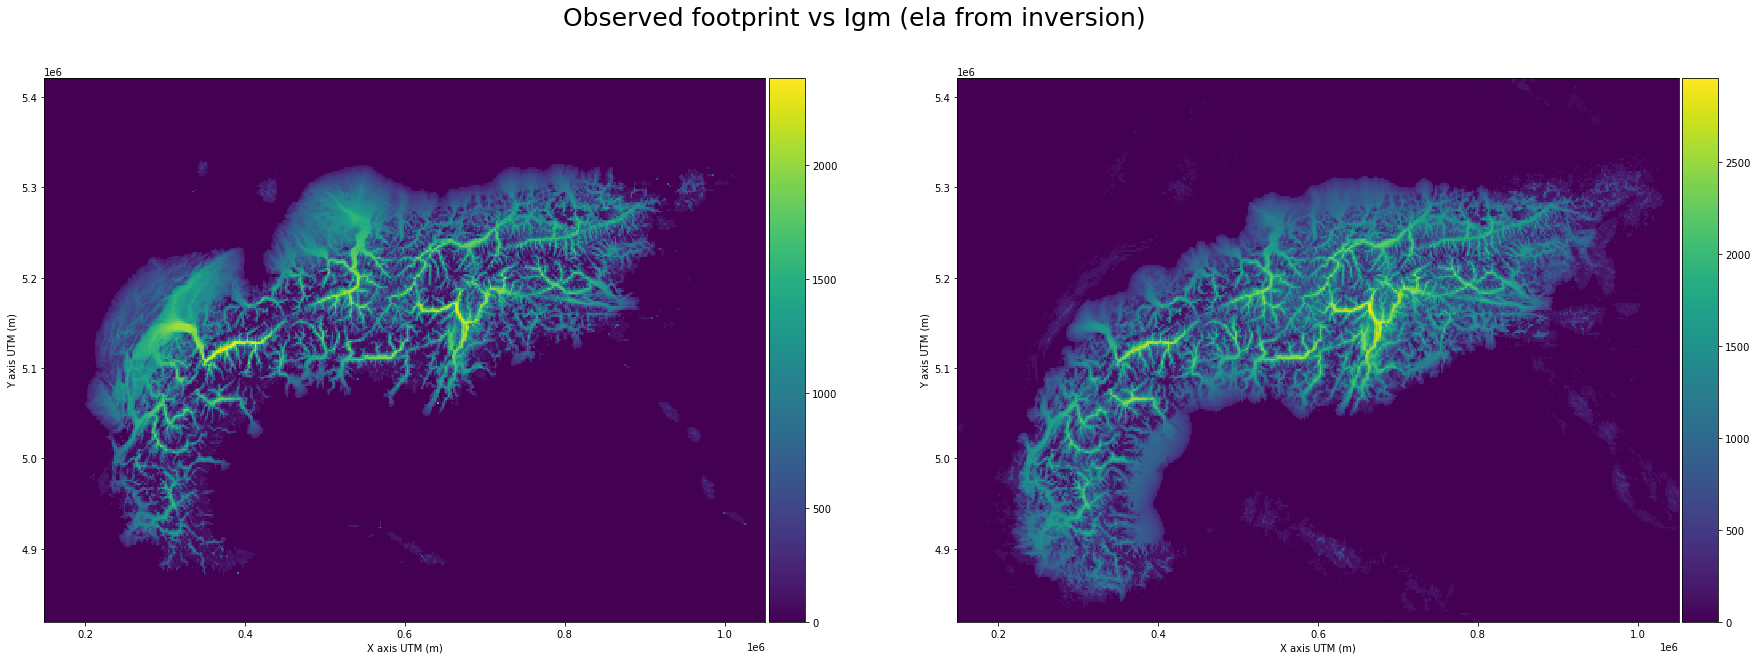

In [4]:
fig = plt.figure(figsize=(30, 10))
fig.suptitle('Observed footprint vs Igm (ela from inversion)',fontsize=25)
ax1 = fig.add_subplot(121)
im1 = ax1.pcolor(X,Y,obs)
ax1.set_xlabel('X axis UTM (m)',fontsize=10)
ax1.set_ylabel('Y axis UTM (m)',fontsize=10)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
im2 = ax2.pcolor(X,Y,footprint)
ax2.set_xlabel('X axis UTM (m)',fontsize=10)
ax2.set_ylabel('Y axis UTM (m)',fontsize=10)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

## Visualize parameter evolution.

In [5]:
param0=np.load('parameterevolution/ela2100.npy')
ela=np.load('ela.npy')

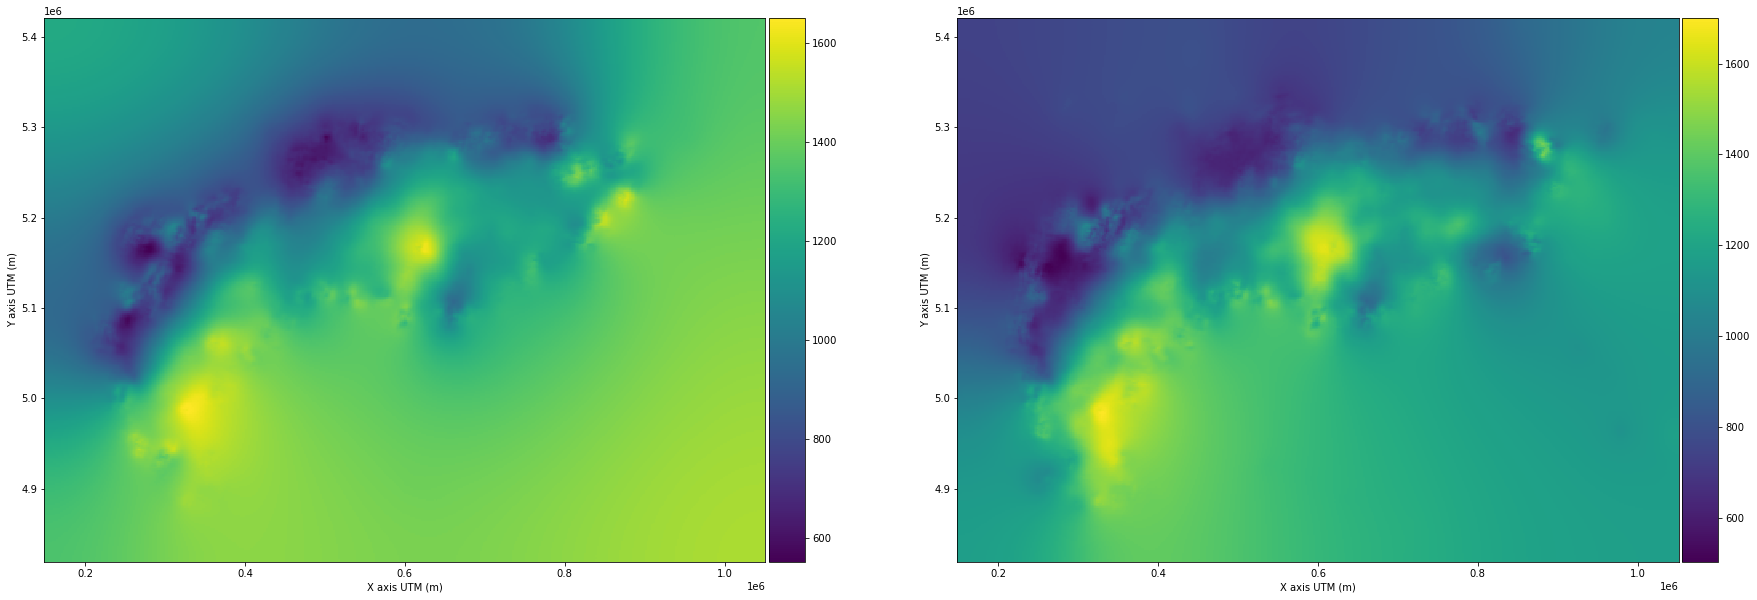

In [6]:
fig = plt.figure(figsize=(30, 10))
#fig.suptitle('Observed footprint vs inversion result',fontsize=25)
ax1 = fig.add_subplot(121)
im1 = ax1.pcolor(X,Y,param0)
ax1.set_xlabel('X axis UTM (m)',fontsize=10)
ax1.set_ylabel('Y axis UTM (m)',fontsize=10)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
im2 = ax2.pcolor(X,Y,ela)
ax2.set_xlabel('X axis UTM (m)',fontsize=10)
ax2.set_ylabel('Y axis UTM (m)',fontsize=10)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

## Test emulator

In [8]:
dirpath='/home/klleshi/Desktop/igm/model-lib/fKD_IGM_KLL_22_a/2000'
iceflow_model = tf.keras.models.load_model(
            os.path.join(dirpath, "model.h5")
        )

In [18]:
def predict(ela_):
    PAD = [[0, 0], [0, 0]]
    X_ = tf.concat(
                        [
                            tf.expand_dims(
                                tf.expand_dims(
                                    tf.pad(topg/4550, PAD, "CONSTANT"), axis=0
                                ),
                                axis=-1,
                            ),
                            tf.expand_dims(
                                tf.expand_dims(
                                    tf.pad(ela_/1210, PAD, "CONSTANT"), axis=0
                                ),
                                axis=-1,
                            ),
                        ],
                        axis=-1,
                    )
    return tf.squeeze(iceflow_model(X_))*2850

In [27]:
Pred = predict(ela).numpy()

In [28]:
Pred

array([[ 0.28625762, -0.31185043, -0.09277202, ..., -0.13959996,
        -0.3757576 ,  6.998937  ],
       [-0.25600758, -0.11264255, -0.06979003, ..., -0.32591343,
        -0.40381986,  1.396358  ],
       [-0.12952437, -0.12818064, -0.04499252, ..., -0.31735772,
        -0.21526721,  0.5133881 ],
       ...,
       [-0.12084955, -0.10196707, -0.0180623 , ...,  0.0524822 ,
        -0.18944848,  0.5305234 ],
       [-0.32852954, -0.29782328, -0.2804929 , ..., -0.2175824 ,
        -0.32559723, -0.19962361],
       [-0.36043617, -0.32944524, -0.14899409, ..., -0.04551077,
        -0.07954314,  0.78027093]], dtype=float32)

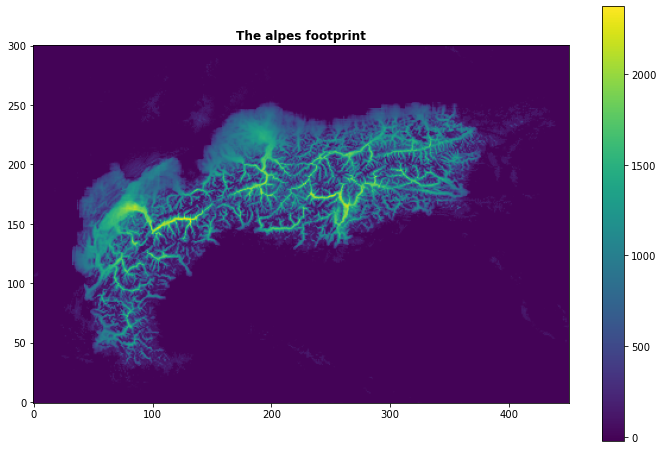

In [21]:
plt.figure(figsize=(12,8))
plt.title('The alpes footprint', fontweight ="bold")
plt.imshow(Pred,cmap ='viridis')
plt.colorbar()
plt.gca().invert_yaxis()

plt.show()

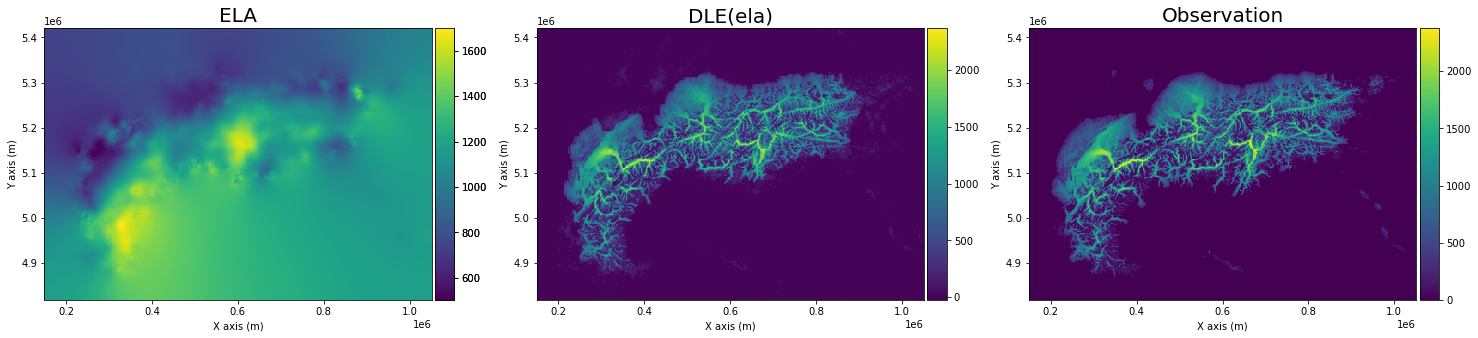

In [29]:
fig = plt.figure(figsize=(25, 5))
#fig.suptitle('ELA  vs Emulator footprint',fontsize=25)

ax1 = fig.add_subplot(131)
im1 = ax1.pcolor(X,Y,ela)
ax1.set_xlabel('X axis (m)',fontsize=10)
ax1.set_ylabel('Y axis (m)',fontsize=10)
ax1.set_title('ELA',fontsize=20)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(132)
im2 = ax2.pcolor(X,Y,Pred)
ax2.set_xlabel('X axis (m)',fontsize=10)
ax2.set_ylabel('Y axis (m)',fontsize=10)
ax2.set_title('DLE(ela)',fontsize=20)


divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax3 = fig.add_subplot(133)
im3 = ax3.pcolor(X,Y,obs)
ax3.set_xlabel('X axis (m)',fontsize=10)
ax3.set_ylabel('Y axis (m)',fontsize=10)
ax3.set_title('Observation',fontsize=20)

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical')

## visualize cost and regularization

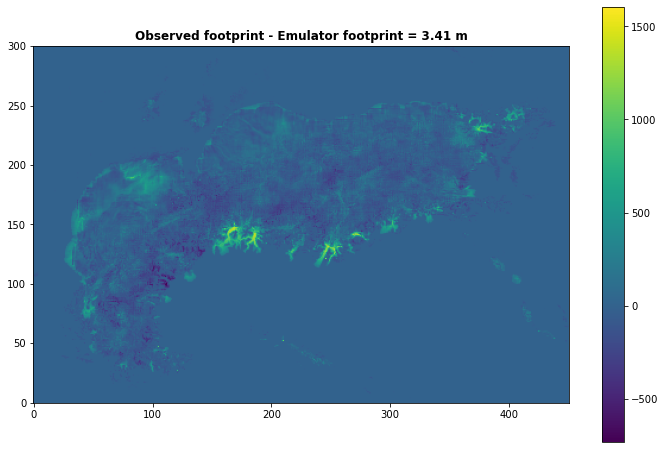

In [31]:
plt.figure(figsize=(12,8))
plt.title('Observed footprint - Emulator footprint = {0:.2f} m'.format(np.mean(obs-Pred)), fontweight ="bold")
plt.imshow(obs-Pred,cmap ='viridis')
plt.colorbar()
plt.gca().invert_yaxis()

plt.show()

### Normalized metrics

In [39]:
path1='/home/klleshi/Desktop/DLE2/fordle/ela_data/test/ALP06_A78_C0/ex.nc'
mae = tf.keras.losses.MeanAbsoluteError()
mse = tf.keras.losses.MeanSquaredError()

In [40]:
dts = nc.Dataset(path1)
#load ela and the corresponding FP.
ela_test=dts['ela']
ela_test=tf.cast(ela_test,tf.float32)
FP_test=dts['max_thk']
FP_test=tf.cast(FP_test,tf.float32)

In [42]:
mae_list=np.zeros(46)
mse_list=np.zeros(46)
for i in range (46):
    Pred_i=predict(ela_test[i])
    obs_i=FP_test[i]
    mae_list[i]= mae(obs_i, Pred_i).numpy()/np.sum(obs_i)
    mse_list[i]= mse(obs_i, Pred_i).numpy()/np.sum(obs_i)
    
    

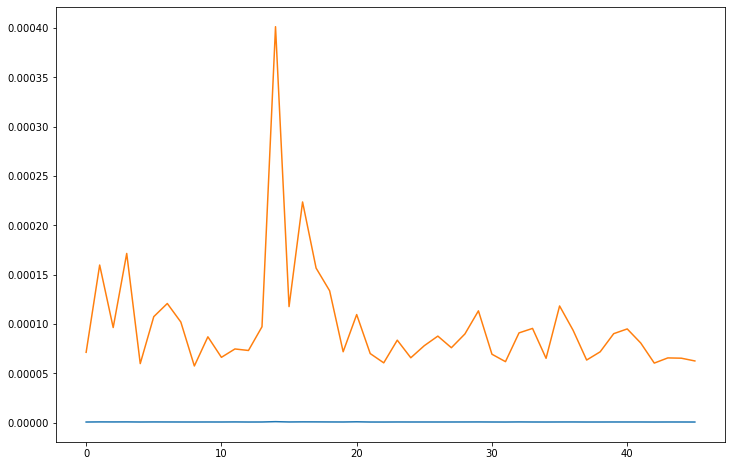

In [44]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(46),mae_list,np.arange(46),mse_list)
plt.show()

In [45]:
print(np.mean(mae_list),np.mean(mse_list))

6.11165647945239e-07 9.850934815324803e-05
